In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
from matplotlib.patches import FancyArrowPatch

In [16]:
data_location = 'data'
pph = xr.load_dataset('data/pph/labelled_pph.nc')
reports = gp.read_file(data_location + '/storm_reports/labelled_reports.csv', engine="pyogrio")

In [3]:
displacements = xr.load_dataset('~/Downloads/displacements.nc')

In [17]:
grid_outlook_location = '~/Downloads/grid_outlooks.nc'
grid_report_location = 'data/storm_reports/grid_reports.nc'

grid_outlooks = xr.open_dataset(grid_outlook_location)
grid_reports = xr.open_dataset(grid_report_location)

In [4]:
def performance_diagram(pods, fars, obj_labels, colors, markers, filename = '', save = False, show = True, figsize=(9, 8), points = True, xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, .6, 0.1), dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=dict(loc=4, fontsize=12, framealpha=1, frameon=True)):
    """
    Draws a performance diagram from a set of POD lists and FAR lists.
    :param pods: list or array of POD arrays.
    :param fars: list or array of FAR arrays.
    :param obj_labels: list or array of labels describing each DistributedROC object.
    :param colors: list of color strings
    :param markers: list of markers.
    :param filename: output filename.
    :param save: whether the figure will be saved
    :param show: whether the figure will be shown in the console
    :param figsize: tuple with size of the figure in inches.
    :param points: True if the plotted points should be separate, otherwise connected
    :param xlabel: Label for the x-axis
    :param ylabel: Label for the y-axis
    :param ticks: Array of ticks used for x and y axes
    :param dpi: DPI of the output image
    :param csi_cmap: Colormap used for the CSI contours
    :param csi_label: Label for the CSI colorbar
    :return:
    """
    plt.style.use('default')
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, .51, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(.025, .325, 0.025), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [.25, 0.5, 1, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.2f", manual=[(0.1, 0.45), (0.2, 0.45), (0.35, 0.35), (.45, .2), (.45, .1)])
    for r, pod, far in zip(range(len(pods)), pods, fars):
        if points:
            plt.scatter(1 - far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], s = 100)
        else:
            plt.plot(1 - far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], markersize = 5, linewidth = 1)
            shift0 = .03
            shift1 = .03
            if r == 3:
                shift1 = 0
            plt.annotate('2002', xy = (1-far[1], pod[1]), xytext=(1-far[1]-shift1, pod[1]+shift0), arrowprops=dict(arrowstyle="->"))
            plt.annotate('2023', xy = (1-far[-1], pod[-1]), xytext=(1-far[-1]+shift0, pod[-1]-shift1), arrowprops=dict(arrowstyle="->"))
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.text(0.24,0.26,"Frequency Bias",fontdict=dict(fontsize=14, rotation=48))

    if len(obj_labels) > 8:
        legend_params=dict(loc='center left', bbox_to_anchor=(1.3, 0.5), fontsize=12, framealpha=1, frameon=True)
    
    plt.legend(**legend_params)

    if save:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    #if show:
    #    plt.show()


In [27]:
def plot_outlooks_day(outlooks_date, output_location, categories, title_date, show=False, save = True):
    # plots day 1, 2, and 3 outlooks for a day of given categories (hail, wind, tornado, categorical)
    outlooks_date['PRODISS'] = parse_datetime(outlooks_date['PRODISS'])
    for category in categories:
        outlooks_category = outlooks_date[outlooks_date['CATEGORY'] == category]
        for day in [[3, 8], [2, 7], [2, 17], [1, 6]]: 
            outlooks_category_day = outlooks_category[(outlooks_category['DAY'] == day[0]) & (outlooks_category['CYCLE'] == day[1])]
            latest_issue_time = np.max(outlooks_category_day['PRODISS'])
            outlooks_category_day = outlooks_category_day[outlooks_category_day['PRODISS'] == latest_issue_time]
            if outlooks_category_day.empty == False:
                fig=plt.figure(figsize=(9,6))
                #plt.style.use('dark_background')
                ax = plt.axes(projection = cp.crs.LambertConformal())
                ax.add_feature(cp.feature.LAND,facecolor='grey')
                ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
                ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
                ax.add_feature(cp.feature.LAKES, alpha = 0.5)
                ax.add_feature(cp.feature.STATES,linewidth=0.5)
                outlooks_category_day.plot('THRESHOLD', legend = True)
                plt.title(title_date + ' Day ' + str(day) + ' ' + category + ' outlook for ' + str(outlooks_category_day['DATE'].iloc[0]))
                cx.add_basemap(ax, crs=outlooks_category_day.crs)
                if save:
                    plt.savefig(output_location + '/day' + str(day) + '_' + category + '_' + str(outlooks_category_day['DATE'].iloc[0]) + '.png')
                if not show:
                    plt.close()

def plot_grid_outlooks_day(grid_outlooks_date, output_location, title_date, show=False, save = True, ax = None):
    # plots day 3, day 2, and day 2 outlooks for a day. Assume that grid_outlooks_date only contains one day
    if ax is None:
        own_fig = True
    else:
        own_fig = False  # plotting on an external axis

    if own_fig: 
        day_list = ['Day 3', 'Day 2 7', 'Day 2 17', 'Day 1']
    else:
        day_list = ['Day 1']
    
    for day in day_list: 

        if own_fig:  # Create a new figure for each day
            fig = plt.figure(figsize=(9,6))
            ax = plt.axes(projection=cp.crs.LambertConformal())
        grid_outlooks_date_outlook = grid_outlooks_date.sel(outlook = day)
        
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        ax.contourf(grid_outlooks_date_outlook.lon.values, grid_outlooks_date_outlook.lat.values, grid_outlooks_date_outlook['prob'].values[:,:],
                    levels=[0,.02], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = ax.contourf(grid_outlooks_date_outlook.lon.values, grid_outlooks_date_outlook.lat.values, grid_outlooks_date_outlook['prob'].values[:,:]+.01,
                    levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            
        except:
            ax.annotate("No Severe Thunderstorms Forecast", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
        
        ax.set_extent([-121, -71, 23, 50])

        if own_fig:
            plt.title(title_date + ' ' + day + ' All-Hazard Outlook')
        else:
            ax.set_title('Day 1 All-Hazard Outlook')

        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        if own_fig:
            if save:
                plt.savefig(output_location + '/outlook_' + str.replace(day, ' ', '_') + '.png')
            if show:
                plt.show()
            plt.close('all')


def plot_pph_day(pph_date, output_location, categories, title_date, show = False, save = True, sig = True, ax = None):
    if ax is None:
        own_fig = True
    else:
        own_fig = False  # plotting on an external axis
        categories = ['totalsvr']
    
    for category in categories:

        if own_fig:  # Create a new figure for each day
            fig = plt.figure(figsize=(9,6))
            ax = plt.axes(projection=cp.crs.LambertConformal())

        pph_date_category = pph_date[['p_perfect_' + category, 'lat', 'lon']]
        if sig:
            pph_date_category_sig = pph_date[['p_perfect_sig_' + category, 'lat', 'lon']]

        
        # credit: https://atlas.niu.edu/pperfect/BAMS/notebook_sample.html
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        ax.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:]/100,
                    levels=[0,2], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = ax.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:]/100,
                    levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            #ax.annotate('PPH Max\n'+str(pph_date_category['p_perfect_' + category].values[:,:].max().round(1))+'%', xy=(0.88, 0.3), xycoords="figure fraction",
            #            va="center", ha="center", color='white',fontsize=12,
            #            bbox=dict(boxstyle="round", fc="k"))
        except:
            ax.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
            
        if sig:    
            try:
                ax.contourf(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                        levels=[10,100], colors='none', hatches=['////'],
                        transform=cp.crs.PlateCarree())
                ax.contour(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                        levels=[10,100], colors=['k'],
                        transform=cp.crs.PlateCarree())
            except:
                pass

        if category == 'tor':
            cat_title = 'Tornado'
        elif category == 'hail':
            cat_title = 'Hail'
        elif category == 'wind':
            cat_title = 'Wind'
        else:
            cat_title = 'All Hazards'

        ax.set_extent([-121, -71, 23, 50])
        if own_fig:
            plt.title(title_date + ' 24 Hour Practically Perfect Hindcast for ' + cat_title)
        else:
            ax.set_title('All-Hazard PPH')
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        if own_fig: 
            if save:
                plt.savefig(output_location + '/pph_' + category + '.png')
            if show:
                plt.show()
            plt.close('all')


def plot_reports(reports, output_location, categories, title_date, show = False, save = True, ax = None):
    
    if ax is None:
        fig = plt.figure(figsize=(9,6))
        #plt.style.use('dark_background')
        ax = plt.axes(projection=cp.crs.LambertConformal())
        own_fig = True
    else:
        own_fig = False  # plotting on an external axis
    
    
    # plots all storm reports in reports
    legend = []
    
    ax.add_feature(cp.feature.LAND,facecolor='grey')
    ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cp.feature.LAKES, alpha = 0.5)
    ax.add_feature(cp.feature.STATES,linewidth=0.5)

    for category in categories:
        reports_category = reports[reports['EVENT_TYPE'] == category]
        reports_category = reports_category[reports_category['BEGIN_LAT'] != '']
        reports_category = reports_category[reports_category['BEGIN_LON'] != '']

        m1 = '.'
        # remove sub-severe
        if category == 'Hail':
            reports_sig = reports_category[reports_category['MAGNITUDE'].astype(float) >= 2.0]
            reports_category = reports_category[(reports_category['MAGNITUDE'].astype(float) >= 1.0) & (reports_category['MAGNITUDE'].astype(float) < 2.0)]
            if not reports_category.empty:
                c1 = 'LimeGreen'
                legend.append('Hail')
            if not reports_sig.empty:
                c2 = 'DarkGreen'
                m2 = '^'
                legend.append('Significant (2 in+) Hail')

        elif category == 'Thunderstorm Wind':
            reports_sig = reports_category[reports_category['MAGNITUDE'].astype(float) >= 65]
            reports_category = reports_category[(reports_category['MAGNITUDE'].astype(float) >= 50) & (reports_category['MAGNITUDE'].astype(float) <65)]
            
            if not reports_category.empty:
                c1 = 'Blue'
                legend.append('Wind')
            if not reports_sig.empty:
                c2 = 'DarkBlue'
                m2 = ','
                legend.append('Significant (75 mph+) Wind')
            
            
        else:
            reports_sig = reports_category[[(cat[-1] != 'U' and cat[-1] != '0' and cat[-1] != '1') for cat in reports_category['TOR_F_SCALE']]]
            reports_category = reports_category[[(cat[-1] == 'U' or cat[-1] == '0' or cat[-1] == '1') for cat in reports_category['TOR_F_SCALE']]]
            
            if not reports_category.empty:
                c1 = 'Red'
                legend.append('Tornado')
            if not reports_sig.empty:  
                c2 = 'DarkRed'
                m2 = 'v'
                legend.append('Significant (EF2+) Tornado')
        

        # plot severe
        if not reports_category.empty:
            ax.scatter(reports_category['BEGIN_LON'].values.astype(float), reports_category['BEGIN_LAT'].values.astype(float), transform=cp.crs.PlateCarree(), marker = m1, color = c1)
        if not reports_sig.empty:
            ax.scatter(reports_sig['BEGIN_LON'].values.astype(float), reports_sig['BEGIN_LAT'].values.astype(float), transform=cp.crs.PlateCarree(), marker = m2, color = c2)


    if own_fig:
        plt.title(title_date + ' Storm Reports')
    else: 
        ax.set_title('Storm Reports')

    if title_date == '05/20/2019':
        ax.legend(legend, bbox_to_anchor=(.48, 1))
    else:
        ax.legend(legend, loc='lower right')

    if own_fig:
        if save:
            plt.savefig(output_location + '/reports.png')
        if show:
            plt.show()
        plt.close()


pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}


def plot_displacement_day(displacements_date, hazards, grid_outlooks_date, grid_pph_date, output_location, title_date, show = False, save = True, composite = True):
    
    if composite:
        if len(hazards) == 4:
            fig_disp, axs_disp = plt.subplots(2, 2, figsize=(18,12),
                                  subplot_kw={'projection': cp.crs.LambertConformal()})
            letters = ['a', 'b', 'c', 'd']
        else:
            fig_disp, axs_disp = plt.subplots(1, 3, figsize=(24,6),
                                  subplot_kw={'projection': cp.crs.LambertConformal()})
            letters = ['a', 'b', 'c']
        fig_disp.suptitle(title_date + ' Outlook Probabilities (colored), PPH Probabilities (dotted), Displacement Vectors, by Hazard Type', fontsize = 16, fontweight = 'bold')
        fig_disp.subplots_adjust(hspace=0.05, wspace=0.05)
        for idx, hazard in enumerate(hazards):
            if len(hazards) == 4:
                rc = divmod(idx, 2)
            else:
                rc = idx
            pph_array = grid_pph_date[pph_key_dict[hazard]].data
            outlook_array = grid_outlooks_date.sel(outlook = outlook_key_dict[hazard])['prob']
            x_flow = displacements_date.sel(hazard = hazard)['x_flow']
            y_flow = displacements_date.sel(hazard = hazard)['y_flow']
            end_lon = displacements_date.sel(hazard = hazard)['end_lon']
            end_lat = displacements_date.sel(hazard = hazard)['end_lat']
            lons = grid_pph_date.lon.values
            lats = grid_pph_date.lat.values

            axs_disp[rc].add_feature(cp.feature.LAND,facecolor='grey')
            axs_disp[rc].add_feature(cp.feature.OCEAN, alpha = 0.5)
            axs_disp[rc].add_feature(cp.feature.COASTLINE,linewidth=0.5)
            axs_disp[rc].add_feature(cp.feature.LAKES, alpha = 0.5)
            axs_disp[rc].add_feature(cp.feature.STATES,linewidth=0.5)
            c = axs_disp[rc].contourf(lons, lats, outlook_array + .01,
                                levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'], transform=cp.crs.PlateCarree())
            axs_disp[rc].contour(lons, lats, pph_array / 100, levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors = 'black', linestyles = 'dashed', linewidths = .5, transform=cp.crs.PlateCarree())

            for i in range(lons.shape[0]):
                for j in range(lats.shape[1]):
                    if np.abs(x_flow[i, j]) > .01 and np.abs(y_flow[i, j]) > .01:
                        axs_disp[rc].add_patch(FancyArrowPatch((lons[i, j], lats[i, j]), (end_lon[i, j], end_lat[i, j]), transform=cp.crs.PlateCarree(), color = 'black', mutation_scale=4, linewidth = .005))
            axs_disp[rc].set_title(hazard)
            plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)

        for idx, letter in enumerate(letters):
            if len(hazards) == 4:
                rc = divmod(idx, 2)
            else:
                rc = idx
            axs_disp[rc].text(0.02, 0.98, letter, transform=axs_disp[rc].transAxes,
                        fontsize=14, fontweight='bold', va='top', ha='left', color='black')

        if save:
            plt.savefig(output_location + '/displacements_by_hazard.pdf', bbox_inches='tight')
        if show:
            plt.show()
        plt.close()

    
    else:
        for hazard in hazards:
            pph_array = grid_pph_date[pph_key_dict[hazard]].data
            outlook_array = grid_outlooks_date.sel(outlook = outlook_key_dict[hazard])['prob']
            x_flow = displacements_date.sel(hazard = hazard)['x_flow']
            y_flow = displacements_date.sel(hazard = hazard)['y_flow']
            end_lon = displacements_date.sel(hazard = hazard)['end_lon']
            end_lat = displacements_date.sel(hazard = hazard)['end_lat']
            lons = grid_pph_date.lon.values
            lats = grid_pph_date.lat.values

            fig=plt.figure(figsize=(9,6), dpi = 1000)
            ax = plt.axes(projection = cp.crs.LambertConformal())
            ax.add_feature(cp.feature.LAND,facecolor='grey')
            ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
            ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
            ax.add_feature(cp.feature.LAKES, alpha = 0.5)
            ax.add_feature(cp.feature.STATES,linewidth=0.5)
            c = ax.contourf(lons, lats, outlook_array + .01,
                                levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'], transform=cp.crs.PlateCarree())
            ax.contour(lons, lats, pph_array / 100, levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors = 'black', linestyles = 'dashed', linewidths = .5, transform=cp.crs.PlateCarree())

            for i in range(lons.shape[0]):
                for j in range(lats.shape[1]):
                    if np.abs(x_flow[i, j]) > .01 and np.abs(y_flow[i, j]) > .01:
                        ax.add_patch(FancyArrowPatch((lons[i, j], lats[i, j]), (end_lon[i, j], end_lat[i, j]), transform=cp.crs.PlateCarree(), color = 'black', mutation_scale=4, linewidth = .01))
            plt.title(title_date + ' ' + hazard + ' Outlook Probabilities (colored), PPH Probabilities (dotted), Displacement Vectors')
            plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
            if save:
                plt.savefig(output_location + '/' + hazard + '_displacement.png')
            if not show:
                plt.close()


In [28]:
# with utils_plotting functions
def plot_day(datestring, grid_outlooks, pph, displacements, reports, folder = 'plots/daily/', show = True, save = False):
    plt.style.use('default')
    grid_outlooks_day = grid_outlooks.sel(time=datestring)
    pph_day = pph.sel(time=datestring)
    reports_day = reports[reports['DATE'] == datestring]
    displacements_day = displacements.sel(time = datestring)

    titledate = dt.strptime(datestring, "%Y%m%d%H%M").strftime("%m/%d/%Y")

    path = folder+datestring
    

    if save:
        if not os.path.exists(path):
            os.makedirs(path)
    
    print('plotting outlooks')
    #plot_grid_outlooks_day(grid_outlooks_day, path, titledate, show = show, save = save)
    
    print('plotting pph')
    #plot_pph_day(pph_day, path, ['totalsvr'], titledate, show=show, save = save, sig = False)

    print('plotting reports')
    #plot_reports(reports_day, path, ['Hail', 'Thunderstorm Wind', 'Tornado'], titledate, show=show, save = save)

    
    # printing composite outlook/pph/report figure

    # Composite figure for grid outlook, PPH, and reports (3x1 layout)
    fig_upper, axs_upper = plt.subplots(1, 3, figsize = (27, 5),
                                        subplot_kw={'projection': cp.crs.LambertConformal()})

    # Call the helper functions to plot into the provided axes.
    # Note: Pass any extra parameters as needed.
    #plot_grid_outlooks_day(grid_outlooks_day, path, titledate, show=show, save=save, ax=axs_upper[0])
    #plot_reports(reports_day, path, ['Hail', 'Thunderstorm Wind', 'Tornado'], titledate, show=show, save=save, ax=axs_upper[1])
    #plot_pph_day(pph_day, path, ['totalsvr'], titledate, show=show, save=save, sig=False, ax=axs_upper[2])
    

    # Remove the individual titles (if any) and add subplot labels (a, b, c)
    #for i, letter in enumerate(['a', 'b', 'c']):
    #    axs_upper[i].text(0.02, 0.98, letter, transform=axs_upper[i].transAxes,
    #                    fontsize=14, fontweight='bold', va='top', ha='left', color='black')

    # Add a custom overall title
    #fig_upper.suptitle(titledate + ' All-Hazard Outlook, PPH, and Reports', fontsize=16, fontweight='bold')
    #fig_upper.subplots_adjust(hspace=0.05, wspace=0.05)
    #if save:
    #    fig_upper.savefig(path + '/' + datestring + '_outlook_pph_report.pdf', bbox_inches='tight')
    #if not show:
    #    plt.close(fig_upper)

    
    print('plotting displacements')
    plot_displacement_day(displacements_day, ['Wind', 'Hail', 'Tornado'], grid_outlooks_day, pph_day, path, titledate, show = show, save = save)
    


    #print('plotting performance diagram')
    #d = performance_diagram([float(pph_day['POD_NUM']), float(pph_day['POD_W_NUM']), float(pph_day['POD_H_NUM']), float(pph_day['POD_T_NUM'])], 
    #                    [float(pph_day['FAR_NUM']), float(pph_day['FAR_W_NUM']), float(pph_day['FAR_H_NUM']), float(pph_day['FAR_T_NUM'])], 
    #                    ['All Hazard', 'Wind', 'Hail', 'Tornado', 'All Hazard'], ['black', 'blue', 'green', 'red'], ['o', 'o', 'o', 'o'], 
    #                    filename = path + '/peformance_diagram.png', save = save, show = show, figsize=(9, 8), points = True, xlabel="Success Ratio (1-FAR)",
    #                    ylabel="Probability of Detection", ticks=np.arange(0, .6, 0.1), dpi=300, csi_cmap="Blues",
    #                    csi_label="Critical Success Index", title=titledate + " Performance Diagram",
    #                    legend_params=dict(loc=4, fontsize=12, framealpha=1, frameon=True))
    
    labelstrs = ''
    labels = ['MAX_CAT', 'RAMP_UP', 'RAMP_DOWN', 'RAMP_CAT', 'SEASON', 'PPH_CAT', 'PPH_NUM', 'REPORT_NUM', 'TOR_NUM', 'WIND_NUM', 'HAIL_NUM', 'TOR_F', 'WINDSP_CAT', 'WINDSP_NUM', 'HAILSZ_CAT', 'HAILSZ_NUM', 'NEIGH_NUM', 'RMSE_NUM', 'BS_NUM', 
               'LAT_NUM', 'LON_NUM', 'PPH_D_CAT', 'PPH_D_NUM',
              'POD_NUM', 'FAR_NUM', 'POD_H_NUM', 'FAR_H_NUM', 'POD_W_NUM', 'FAR_W_NUM', 'POD_T_NUM', 'FAR_T_NUM', 
              'E_SH_NUM','N_SH_NUM','DIV_NUM',
              'E_SH_W_NUM', 'N_SH_W_NUM', 'DIV_W_NUM',
              'E_SH_H_NUM', 'N_SH_H_NUM', 'DIV_H_NUM',
              'E_SH_T_NUM', 'N_SH_T_NUM', 'DIV_T_NUM',
              'PC_W_NUM', 'PC_H_NUM', 'PC_T_NUM', 'PC_NUM',
              'POFD_W_NUM', 'POFD_H_NUM', 'POFD_T_NUM', 'POFD_NUM',
              'DFR_W_NUM', 'DFR_H_NUM', 'DFR_T_NUM', 'DFR_NUM', 
              'CSI_W_NUM', 'CSI_H_NUM', 'CSI_T_NUM', 'CSI_NUM', 
              'Bias_W_NUM', 'Bias_H_NUM', 'Bias_T_NUM', 'Bias_NUM',
              'ETS_W_NUM', 'ETS_H_NUM', 'ETS_T_NUM', 'ETS_NUM',
              'TSS_W_NUM', 'TSS_H_NUM', 'TSS_T_NUM', 'TSS_NUM',
              ]#'EE_S_NUM', 'EW_S_NUM', 'EE_S_W_NUM', 'EW_S_W_NUM', 'EE_S_H_NUM', 'EW_S_H_NUM', 'EE_S_T_NUM', 'EW_S_T_NUM']
    for label in labels:
        labelstr = label + ': ' + str(pph_day[label].data)
        labelstrs += labelstr + '\n'
    #if show:
    #    print(labelstrs)
    if save:
        with open(path + '/labels.txt', "w") as file:
            file.write(labelstrs)


    return


plotting outlooks
plotting pph
plotting reports
plotting displacements


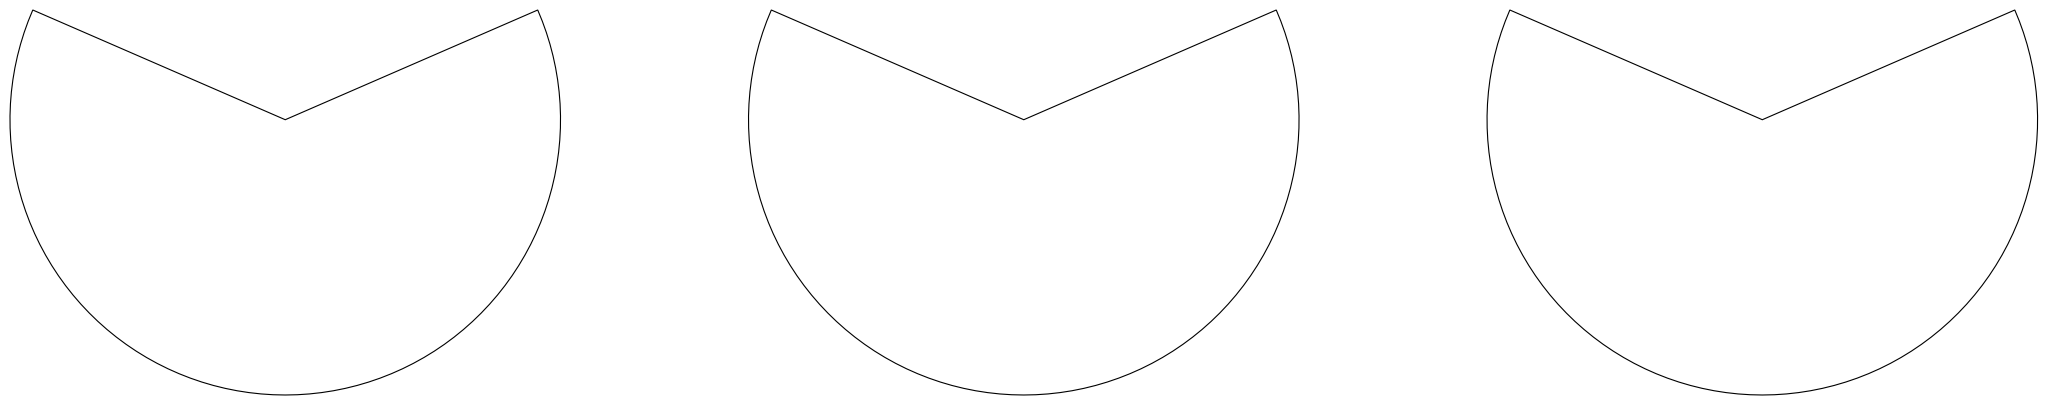

In [29]:
plot_day('201905200000', grid_outlooks, pph, displacements, reports, show = False, save = True)

In [ ]:
# to determine dates of interest
mdt_outlooks = outlooks[outlooks['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_outlooks = mdt_outlooks[mdt_outlooks['DATE'] >= '200203300000']
mdt_outlooks[mdt_outlooks['FAR_NUM'] == 0]['DATE'].unique()

In [28]:
dates_of_interest = ['200703280000', '201905200000', '200306220000', '200504220000', '200509140000', '200510240000', '200612010000', '201010100000', '201104040000', '201104270000', '201305310000', '201701220000', '201704020000', '201704050000', '201705180000', '202103170000', '202103250000', '202303310000']
for date in dates_of_interest:
    print(date)
    plot_day(date, grid_outlooks, pph, displacements, reports, show = False, save = True)

200703280000
plotting outlooks
plotting pph
plotting reports
plotting displacements
201905200000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200306220000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200504220000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200509140000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200510240000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200612010000
plotting outlooks
plotting pph
plotting reports
plotting displacements
201010100000
plotting outlooks
plotting pph
plotting reports
plotting displacements
201104040000
plotting outlooks
plotting pph
plotting reports
plotting displacements
201104270000
plotting outlooks
plotting pph
plotting reports
plotting displacements
201305310000
plotting outlooks
plotting pph
plotting reports
plotting displacements
201701220000
plotting outlooks
plotting pph
plotting reports
plotting displa

In [9]:
dates_of_interest = ['200204190000', '200204200000', '200204210000', '200204250000', '200205060000', '200205250000', '200207310000', '200208130000', '200208300000', '200211090000', '200212230000', '200302030000', '200303250000', '200304140000', '200304150000', '200304160000', '200305100000', '200306250000', '200306280000', '200307270000', '200307280000', '200309030000', '200312280000', '200404020000', '200404140000', '200405230000', '200408090000', '200410140000', '200503300000', '200506060000', '200508030000', '200701040000', '200905280000', '201105210000', '202005240000', '202106130000']
for date in dates_of_interest:
    print(date)
    plot_day(date, grid_outlooks, pph, displacements, reports, 'plots/daily/missing/', show = False, save = True)

200410140000
plotting outlooks
plotting pph
plotting reports
plotting displacements


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cartopy\mpl\geoaxes.py:1604: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cartopy\mpl\geoaxes.py:1604: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


200503300000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200506060000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200508030000
plotting outlooks
plotting pph
plotting reports
plotting displacements
200701040000
plotting outlooks
plotting pph
plotting reports
plotting displacements


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cartopy\mpl\geoaxes.py:1604: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


200905280000
plotting outlooks
plotting pph
plotting reports
plotting displacements


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cartopy\mpl\geoaxes.py:1604: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


201105210000
plotting outlooks
plotting pph
plotting reports
plotting displacements
202005240000
plotting outlooks
plotting pph
plotting reports
plotting displacements
202106130000
plotting outlooks
plotting pph
plotting reports
plotting displacements


In [ ]:
dates_of_interest = ['200205190000', '200207220000', '200207240000', '200308070000',
       '200504220000', '200505280000', '200506190000', '200506200000',
       '200506210000', '200507210000', '200605230000', '200806300000',
       '200807020000', '200808070000', '200906040000', '201005270000',
       '201103150000', '201207140000', '201207170000', '201307310000',
       '201308100000', '201309050000', '201408120000', '201506280000',
       '201508100000', '201604200000', '201705040000', '201806200000',
       '202005300000', '202009170000']
for date in dates_of_interest:
    print(date)
    plot_day(date, grid_outlooks, pph, displacements, reports, 'plots/daily/pnw/', show = False, save = True)